In [25]:
%reload_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
from polymers import plot_walk
from numba import njit

rng = np.random.default_rng(123)

In [26]:
def possible_steps(*, d=2):
    """returns a list of all possible steps of length 1 in d dimensions
    
    e.g.,
    ```python
    >>> gen_possible_steps(2)
    array([[-1.,  0.],
           [ 0., -1.],
           [ 0.,  1.],
           [ 1.,  0.]])
    ```
    """
    return np.vstack([-np.eye(d), np.eye(d)[::-1]])

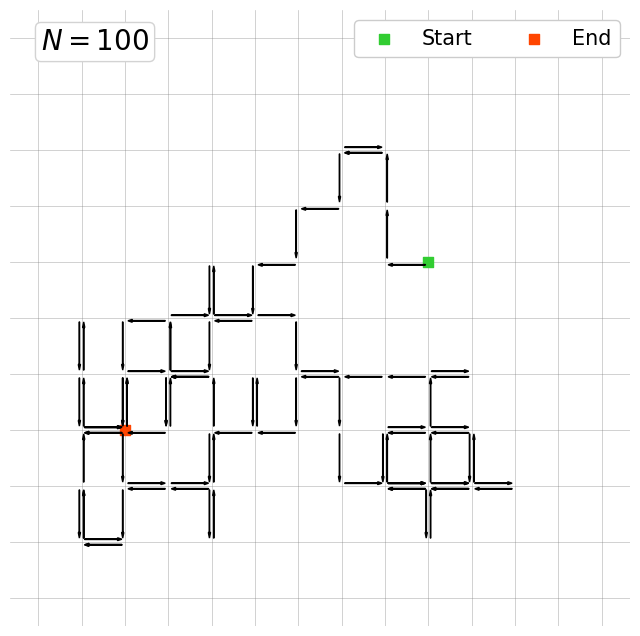

In [27]:
def simpl_rnd_walk(n, *, d=2):
    """
    Generates a simple random walk of length n in d dimensions:
    
    1. Start at the origin
    2. At each step, move one unit in a random direction
    3. Repeat until n steps have been taken
    
    Args:
        n (int): the length of the walk
        d (int): the number of dimensions
    Returns:
        (x, y) (list, list): Random walk of length n
    """
    walk = np.array([[0] for _ in range(d)])
    deltas = possible_steps(d=d) #possible directions for the 2D lattice
    for _ in range(n):
        step = deltas[rng.integers(0,len(deltas))]   #direction chosen at random
        walk = np.hstack([walk, (walk[:,-1]+step).reshape(-1,1)])

    dim_names = "xyz" if d <= 3 else list(range(d))
    out_dict = {}
    for i in range(d):
        out_dict[dim_names[i]] = walk[i]
    out_dict.update(dict(n=n))
    return out_dict
plot_walk(simpl_rnd_walk(100), dx=0.05, gap=0.07)

In [28]:
def is_valid(*dims):
    """
    Checks if the walk is non-intersecting by checking for any duplicates (x,y) coordinates.
    """
    return len(dims[0]) == len(set(zip(*dims)))


In [29]:
def naive_self_avoiding_walk(n, *, d=2, ntries=1):
    """
    Generates a self-avoiding walk of length n in d dimensions via rejection sampling
    
    Args:
        n (int): the length of the walk
        d (int): the number of dimensions
    Returns:
        (x, y) (list, list): Self-avoiding walk of length n
    """

    walk = np.array([[0] for _ in range(d)])
    candidate_steps = possible_steps(d=d)      # left, up, right, down in d dimensions
    
    while True:
        if len(walk[0]) == n+1:                                # if we've reached the desired length, stop
            break

        feasible_steps = []                              # check which possible steps are valid (i.e. don't intersect)
        for step in candidate_steps:
            if tuple(walk[:,-1]+step) not in zip(*walk):
                feasible_steps.append(step)
            
        if len(feasible_steps) > 0:                      # if there are valid steps, take one at random
            step = feasible_steps[rng.integers(0,len(feasible_steps))]
            walk = np.hstack([walk, (walk[:,-1]+step).reshape(-1,1)])
        else:                                            # if there are no valid steps, we're stuck :-( let's try again
            try:
                return naive_self_avoiding_walk(n, d=d, ntries=ntries+1)
            except RecursionError:
                break

    return walk

def dimer(n):
    """
    Generates a SAW of length n by dimerization
    
    Args:
        n (int): the length of the walk
    Returns:
        (x, y) (list, list): SAW of length n
    """
    if n <= 200:
        walk = naive_self_avoiding_walk(n) #base case uses the myopic algorithm
        return walk
    else:
        not_saw = 1
        while not_saw:
            walk_1 = dimer(n//2)  #recursive call
            walk_2 = dimer(n-n//2)  #recursive call
            
            walk_2 = walk_2 + walk_1[:,-1].reshape(-1,1)  #translates the second walk to the end of the first one
            walk_concat = np.hstack([walk_1, walk_2[:,1:]])  #concatenates the x coordinates
            if is_valid(*walk_concat):   #if walk obtained is SAW, stop
                not_saw = 0
        return walk_concat

In [30]:
def r_k(k, n):
    """
    r_k is a rotation matrix, expressing a counterclockwise 
    rotation through an angle of 2πk/n.
    """
    return np.round(np.array([
        [np.cos(2*np.pi*k/n), -np.sin(2*np.pi*k/n)],
        [np.sin(2*np.pi*k/n), np.cos(2*np.pi*k/n)]
        ]), 4)
    
def s_k(k, n):
    """
    s_k is a reflection matrix, expressing a reflection 
    through the line y = tan(πk/n)x.
    """
    return np.round(np.array([
        [np.cos(2*np.pi*k/n), np.sin(2*np.pi*k/n)],
        [np.sin(2*np.pi*k/n), -np.cos(2*np.pi*k/n)]
        ]), 4)

D4 = np.array([r_k(k, 4) for k in range(4)] + [s_k(k, 4) for k in range(4)])
D4

array([[[ 1., -0.],
        [ 0.,  1.]],

       [[ 0., -1.],
        [ 1.,  0.]],

       [[-1., -0.],
        [ 0., -1.]],

       [[-0.,  1.],
        [-1., -0.]],

       [[ 1.,  0.],
        [ 0., -1.]],

       [[ 0.,  1.],
        [ 1., -0.]],

       [[-1.,  0.],
        [ 0.,  1.]],

       [[-0., -1.],
        [-1.,  0.]]])

In [31]:
import numpy as np

import functools

def random_transform(dim=3, rng=np.random.default_rng(1)):
    mx = np.eye(dim).astype(int)
    for i in range(dim):
        ival = int((i+1)*rng.random())
        
        # swap rows
        for ii in range(dim):
            mx[i, ii] = mx[ival, ii]
            mx[ival, ii] = 0
        
        if rng.random()<0.5:
            mx[ival, i] = -1
        else:
            mx[ival, i] = 1      
    return mx

@functools.lru_cache(maxsize=None)
def Gd(dim=2):
    t = np.unique([random_transform(dim) for _ in range(10000)], axis=0)
    t = [t for t in t if not np.allclose(t, np.eye(dim))]
    return t

def rand_Gd(dim=2, rng=np.random.default_rng(1)):
    return Gd(dim=dim)[rng.integers(0, len(Gd(dim=dim)))]

From Madras & Sokal:

1. A site on the walk is chosen at random and used as a pivot point
2. A random symmetry operation is chosen and applied to the part of the walk subsequent to eh pivot point, using the pivot point as the origin.
3. If the walk is self-avoiding, the new walk is accepted; otherwise, the old walk is retained.


Let G be the group of orthogonal transformationsa bout the prigin that leave invariant the lattice $\mathbb{Z}^d$.Then the symmeytry operation $g \in G$ is a matrix $d \times d$ with integer entries and determinant $\pm 1$. For $d=2$, the group $G$ is the dihedral group $D_4$ [[1]](https://en.wikipedia.org/wiki/Dihedral_group).


[1] https://en.wikipedia.org/wiki/Dihedral_group



In [41]:
def Xe(w):
    return w[-1]

def X(w):
    return w.sum(axis=0)

@njit
def X2(w):
    out = 0
    for i in range(len(w)):
        out += (w[i] * w[i]).sum()
    return out

def Re2(w):
    return np.linalg.norm((w(-1) - w[0]))**2

def Rg2(w):
    return X2(w)/len(w) - 1/len(w)**2 * (X(w) @ X(w))

def Rm2(w):
    """mean-square end-to-end distance"""
    n = len(w)
    return 0.5 + 0.5 * Xe(w) @ X(w) - 1/n * Xe(w) @ X(w) + 1/n * X2(w)

In [48]:
from polymers.naive import naive_self_avoiding_walk
Rm2(naive_self_avoiding_walk(10, 2))

58.0

In [35]:
from tqdm import trange

def pivot(n, samples, burn_in=0, *, d=2, save_walks=True):
    """
    Initialized with a straight line in the 1st dimension and zeros in all other dimensions.
    
    At every step, we:
    1. choose a random point on the line, and use it as a pivot point
    2. choose a random transformation from the set of possible transformations
    3. apply the transformation to the part of the walk before the pivot point around the pivot point
        (i.e. using it as the origin)
    4. if the resulting walk is valid (i.e. non-intersecting), keep it. otherwise, discard it!
    """
    walk = np.zeros((d, n+1))
    walk[0] = np.arange(n+1)

    if save_walks:
        results = []
    else:
        results = None

    successful_pivots = 0
    for sample in trange(samples):
        i = rng.integers(0, n)
        transform = rand_Gd(dim=d)
        walk_pre, walk_post = walk[:,:i+1], walk[:,i+1:]
        pivot_point = walk[:,i].reshape(-1,1)
        
        if i < n / 2:
            walk_pre = transform @ (walk_pre - pivot_point) + pivot_point
        else:
            walk_post = transform @ (walk_post - pivot_point) + pivot_point

        walk_pivoted = np.hstack([walk_pre, walk_post])
        # if fast_intersect(walk_pre, walk_post):
        #     if save_walks:
        #         if sample >= burn_in:
        #             results.append(walk_pivoted)
        #     else:
        #         results = walk_pivoted
        #     successful_pivots += 1
        if is_valid(*walk_pivoted):
            successful_pivots += 1
            if save_walks:
                if sample >= burn_in:
                    results.append(walk_pivoted)
            else:
                results = walk_pivoted
            walk = walk_pivoted
        elif save_walks and sample >= burn_in:
            results.append(walk)
    return np.asarray(results), successful_pivots / samples

In [36]:
%time pivot(100, int(20*100/0.40))

100%|██████████| 5000/5000 [00:00<00:00, 19241.57it/s]

CPU times: user 250 ms, sys: 70.9 ms, total: 321 ms
Wall time: 313 ms


(array([[[  0.,   1.,   2., ...,  83.,  83.,  83.],
         [  0.,   0.,   0., ...,  15.,  16.,  17.]],
 
        [[ 12.,  12.,  12., ...,  83.,  83.,  83.],
         [-12., -11., -10., ...,  15.,  16.,  17.]],
 
        [[ 14.,  15.,  16., ...,  83.,  83.,  83.],
         [-14., -14., -14., ...,  15.,  16.,  17.]],
 
        ...,
 
        [[ 50.,  50.,  51., ...,  40.,  40.,  41.],
         [-16., -17., -17., ...,  -6.,  -7.,  -7.]],
 
        [[ 50.,  50.,  51., ...,  40.,  40.,  41.],
         [-16., -17., -17., ...,  -6.,  -7.,  -7.]],
 
        [[ 50.,  50.,  51., ...,  40.,  40.,  41.],
         [-16., -17., -17., ...,  -6.,  -7.,  -7.]]]),
 0.3938)

In [37]:
results = pivot(1000, 1000, 100, d=2, save_walks=False)

100%|██████████| 1000/1000 [00:00<00:00, 7357.91it/s]


In [41]:
Ns = np.linspace(10, 5000, 25).astype(int)
fs = []
for N in Ns:
    nsamples = 1e6
    f = pivot(N, nsamples, d=2, save_walks=False)[1]
    fs.append(f)

100%|██████████| 10000/10000 [00:07<00:00, 1339.41it/s]


In [12]:
def f(N, C, gamma, D):
    return C*N**gamma + D

In [ ]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(f, Ns, fs, p0=[1, -0.1, 0.25], maxfev=10000)
plt.plot(Ns, fs, 'o', label='data', c='k')
X = np.linspace(10, 5000, 100)
plt.plot(X, f(X, *popt), 'r-', label='fit')
plt.xlabel('N')
plt.ylabel('f')
plt.legend()
plt.show()
np.save('../data/pivot_fit.npy', popt)
plt.plot(Ns, np.array(Ns)/f(np.array(Ns), *popt), 'o', c='k')
plt.xlabel('N')
plt.ylabel('N/f')
plt.show()


In [53]:
popt = np.load('../data/pivot_fit.npy')
popt

array([ 1.11014839, -0.44135605,  0.22904723])

In [14]:
def get_burn_in(N):
    popt = np.load('../data/pivot_fit.npy')
    return int(N/f(N, *popt))

In [15]:
import time


def find_intersect_time(n, samples, burn_in=0, *, d=2):
    """
    Initialized with a straight line in the 1st dimension and zeros in all other dimensions.
    
    At every step, we:
    1. choose a random point on the line, and use it as a pivot point
    2. choose a random transformation from the set of possible transformations
    3. apply the transformation to the part of the walk before the pivot point around the pivot point
        (i.e. using it as the origin)
    4. if the resulting walk is valid (i.e. non-intersecting), keep it. otherwise, discard it!
    """
    walk = np.zeros((d, n+1))
    walk[0] = np.arange(n+1)

    times = []

    successful_pivots = 0
    for sample in trange(samples):
        i = rng.integers(0, n)
        transform = rand_Gd(dim=d)
        walk_pre, walk_post = walk[:,:i+1], walk[:,i+1:]
        pivot_point = walk[:,i].reshape(-1,1)
        
        if i < n / 2:
            walk_pre = transform @ (walk_pre - pivot_point) + pivot_point
        else:
            walk_post = transform @ (walk_post - pivot_point) + pivot_point

        walk_pivoted = np.hstack([walk_pre, walk_post])

        t0 = time.time()
        if is_valid(*walk_pivoted):
            times.append(time.time() - t0)
            successful_pivots += 1
            walk = walk_pivoted
        else:
            times.append(time.time() - t0)
    return times

In [16]:
avg_times = []
std_times = []

Ns = np.linspace(10, 5000, 10).astype(int)
for N in Ns:
    burn_in = get_burn_in(N)
    times = find_intersect_time(N, burn_in+10000, burn_in=burn_in, d=3)
    avg_times.append(np.mean(times))
    std_times.append(np.std(times))

 40%|███▉      | 6401/16173 [00:01<00:02, 4426.66it/s]


KeyboardInterrupt: 

In [49]:
avg_times = np.array(avg_times)
std_times = np.array(std_times)

<ErrorbarContainer object of 3 artists>

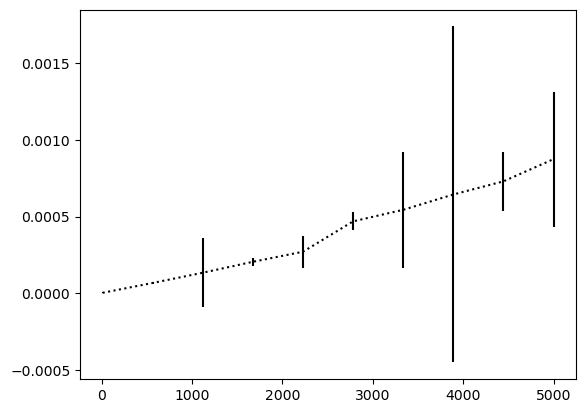

In [51]:
plt.errorbar(Ns, avg_times, yerr=std_times, ls='dotted', c='k')

In [58]:
def model(N, Dx, bx, deltaNx, Delta1, nu, Nmin):
    N = N[N>=Nmin]
    return Dx * (N+deltaNx)**(2*nu) * (1 + bx / (N+deltaNx)**Delta1)

In [34]:
def batch_pivot(n, sample_size, batch_size, burn_in=None, *, d=2, save_walks=True):
    """
    Initialized with a straight line in the 1st dimension and zeros in all other dimensions.
    
    At every step, we:
    1. choose a random point on the line, and use it as a pivot point
    2. choose a random transformation from the set of possible transformations
    3. apply the transformation to the part of the walk before the pivot point around the pivot point
        (i.e. using it as the origin)
    4. if the resulting walk is valid (i.e. non-intersecting), keep it. otherwise, discard it!
    """
    walk = np.zeros((d, n+1))
    walk[0] = np.arange(n+1)
    if burn_in is None:
        burn_in = get_burn_in(n)

    results = []

    Re2s = []
    for sample in trange(sample_size):
        i = rng.integers(0, n)
        transform = rand_Gd(dim=d)
        walk_pre, walk_post = walk[:,:i+1], walk[:,i+1:]
        pivot_point = walk[:,i].reshape(-1,1)
        
        if i < n / 2:
            walk_pre = transform @ (walk_pre - pivot_point) + pivot_point
        else:
            walk_post = transform @ (walk_post - pivot_point) + pivot_point

        walk_pivoted = np.hstack([walk_pre, walk_post])

        if is_valid(*walk_pivoted):
            if sample >= burn_in and sample % batch_size == 0:
                Re2s.append(Re2(walk))
            walk = walk_pivoted
        elif save_walks and sample >= burn_in:
            results.append(walk)
    return Re2s

In [37]:
avg_Re2s = []
std_Re2s = []

Ns = np.linspace(10, 10000, 15).astype(int)
for N in Ns:
    burn_in = get_burn_in(N)
    Re2s = batch_pivot(N, burn_in+10**6, 250, burn_in=burn_in, d=2)
    avg_Re2s.append(np.mean(Re2s))
    std_Re2s.append(np.std(Re2s))

  0%|          | 0/25015 [00:00<?, ?it/s]

100%|██████████| 65306/65306 [01:53<00:00, 577.01it/s]


<ErrorbarContainer object of 3 artists>

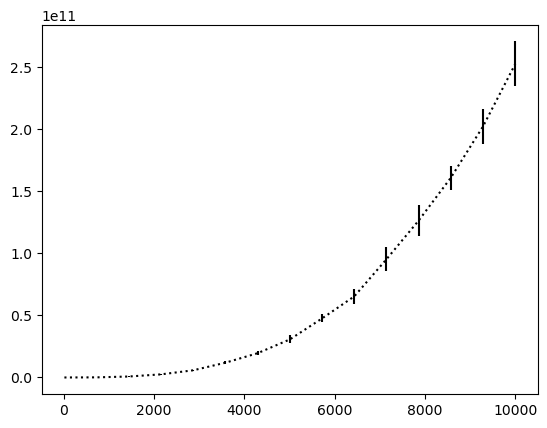

In [39]:
np.save('../data/Re2s.npy', np.array([Ns, avg_Re2s, std_Re2s]))
plt.errorbar(Ns, avg_Re2s, yerr=std_Re2s, ls='dotted', c='k')

In [51]:
for i in range(len(Ns)):
    print(str(Ns[i])+','+str(avg_Re2s[i]))

10,270.8666666666667
723,97161315.84615384
1437,774021347.6896552
2150,2509003658.428571
2864,5791468934.285714
3577,11891823214.076923
4291,19558168101.04
5005,30657983201.8
5718,47561488747.42105
6432,65331850455.75
7145,95233012589.66667
7859,126444793889.52942
8572,160950599675.26315
9286,202337472297.66666
10000,252652501786.25


In [2]:
with open('Re2s.txt', 'w') as f:
    f.write("""10,270.8666666666667
723,97161315.84615384
1437,774021347.6896552
2150,2509003658.428571
2864,5791468934.285714
3577,11891823214.076923
4291,19558168101.04
5005,30657983201.8
5718,47561488747.42105
6432,65331850455.75
7145,95233012589.66667
7859,126444793889.52942
8572,160950599675.26315
9286,202337472297.66666
10000,252652501786.25""")

In [5]:
import numpy as np

Re2s = np.loadtxt('Re2s.txt', delimiter=',')
Re2s.T

array([[1.00000000e+01, 7.23000000e+02, 1.43700000e+03, 2.15000000e+03,
        2.86400000e+03, 3.57700000e+03, 4.29100000e+03, 5.00500000e+03,
        5.71800000e+03, 6.43200000e+03, 7.14500000e+03, 7.85900000e+03,
        8.57200000e+03, 9.28600000e+03, 1.00000000e+04],
       [2.70866667e+02, 9.71613158e+07, 7.74021348e+08, 2.50900366e+09,
        5.79146893e+09, 1.18918232e+10, 1.95581681e+10, 3.06579832e+10,
        4.75614887e+10, 6.53318505e+10, 9.52330126e+10, 1.26444794e+11,
        1.60950600e+11, 2.02337472e+11, 2.52652502e+11]])

In [24]:
def model(N, Dx, nu):
    return Dx * (N)**(2*nu) # * (1 + bx / (N+abs(dN))**Delta1)

ns, re = Re2s.T

from scipy.optimize import curve_fit
popt, pcov = curve_fit(model,*Re2s.T, p0=[1.22, 3/4], maxfev=10000)
for v,err in zip(popt, np.sqrt(np.diag(pcov))):
    print(f'{v:.4f} ± {err:.4f}')

0.3164 ± 0.0698
1.4879 ± 0.0121


/var/folders/w7/xwdclb5101q6zdxfxf7910pr0000gp/T/ipykernel_79645/991968904.py:2: RuntimeWarning: overflow encountered in power
  return Dx * (N)**(2*nu) # * (1 + bx / (N+abs(dN))**Delta1)


In [208]:
walk1 = naive_self_avoiding_walk(3)
walk2 = naive_self_avoiding_walk(3)

def is_valid_two(walk1, walk2):
    walk2_shifted = walk2 + walk1[:,-1].reshape(-1,1)
    return len(set(zip(*walk1))) == len(walk1) and len(set(zip(*walk2))) == len(walk2) and len(set(zip(*np.hstack([walk1, walk2])))) == len(walk1) + len(walk2)

In [214]:
walk2_shifted = walk2 + walk1[:,-1].reshape(-1,1)
set(zip(*walk1)).isdisjoint(set(zip(*walk2_shifted[:,1:])))

True